# Automatic Jupyter Notebook for OpenML dataset

In [13]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import openml as oml
import numpy as np
from matplotlib import cm
from matplotlib.ticker import FormatStrFormatter

plt.rcParams['figure.dpi']= 120
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8 

from preamble import *
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

from pymongo import MongoClient

Build Random Forest model from the dataset and compute important features. 

In [14]:
def build_forest(dataset):    
    data = oml.datasets.get_dataset(dataset) 
    X, y, features = data.get_data(target=data.default_target_attribute, return_attribute_names=True); 
    forest = Pipeline([('Imputer', preprocessing.Imputer(missing_values='NaN', strategy='mean', axis=0)),
                       ('classifiers', RandomForestClassifier(n_estimators=100, random_state=0))])
    forest.fit(X,y)
    
    importances = forest.steps[1][1].feature_importances_
    indices = np.argsort(importances)[::-1]
    return data.name, features, importances, indices 

Plot Top-20 important features for the dataset. 

In [15]:
def plot_feature_importances(features, importances, indices):
    a = 0.8
    f_sub = []
    max_features = 20

    for f in range(min(len(features), max_features)): 
            f_sub.append(f)

    # Create a figure of given size
    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111)
    # Set title
    ttl = dataset_name

    df = pd.DataFrame(importances[indices[f_sub]][::-1])
    df.plot(kind='barh', ax=ax, alpha=a, legend=False, edgecolor='w', 
            title=ttl, color = [plt.cm.viridis(np.arange(len(df))*10)])

    # Remove grid lines and plot frame
    ax.grid(False)
    ax.set_frame_on(False)

    # Customize title
    ax.set_title(ax.get_title(), fontsize=14, alpha=a, ha='left', x=0, y=1.0)
    plt.subplots_adjust(top=0.9)

    # Customize x tick lables
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    ax.locator_params(axis='x', tight=True, nbins=5)

    # Customize y tick labels
    yticks = np.array(features)[indices[f_sub]][::-1]
    ax.set_yticklabels(yticks, fontsize=8, alpha=a)
    ax.yaxis.set_tick_params(pad=2)
    ax.yaxis.set_ticks_position('none')  
    ax.set_ylim(ax.get_ylim()[0]-0.5, ax.get_ylim()[1]+0.5) 

    # Set x axis text
    xlab = 'Feature importance'
    ax.set_xlabel(xlab, fontsize=10, alpha=a)
    ax.xaxis.set_label_coords(0.5, -0.1)

    # Set y axis text
    ylab = 'Feature'
    ax.set_ylabel(ylab, fontsize=10, alpha=a)
    plt.show() 

Choose desired dataset and generate the most important plot. 

In [16]:
dataset =102

In [12]:
dataset_name, features, importances, indices = build_forest(dataset)
plot_feature_importances(features, importances, indices)

OpenMLServerError: OpenML Server error: <oml:error xmlns:oml="http://openml.org/openml">
	<oml:code>111</oml:code>
	<oml:message>Unknown dataset</oml:message>
	</oml:error>


The following Landmarking meta-features were calculated and stored in MongoDB: (Matthias Reif et al. 2012, Abdelmessih et al. 2010)

The accuracy values of the following simple learners are used: Naive Bayes, Linear Discriminant Analysis, One-Nearest Neighbor, Decision Node, Random Node.

- **Naive Bayes Learner** is a probabilistic classifier, based on Bayes’ Theorem:
$$ p(X|Y) = \frac{p(Y|X) \cdot p(X)}{p(Y)} $$

    where p(X) is the prior probability and p(X|Y) is the posterior probability. It is called naive, because it
    assumes independence of all attributes to each other.
- **Linear Discriminant Learner** is a type of discriminant analysis, which is understood as the grouping and separation of categories according to specific features. Linear discriminant is basically finding a linear combination of features that separates the classes best. The resulting separation model is a line, a plane, or a hyperplane, depending on the number of features combined. 

- **One Nearest Neighbor Learner** is a classifier based on instance-based learning. A test point is assigned to the class of the nearest point within the training set. 

- **Decision Node Learner** is a classifier based on the information gain of attributes. The information gain indicates how informative an attribute is with respect to the classification task using its entropy. The higher the variability of the attribute values, the higher its information gain. This learner selects the attribute with the highest information gain. Then, it creates a single node decision tree consisting of the chosen attribute as a split node. 

- **Randomly Chosen Node Learner** is a classifier that results also in a single decision node, based on a randomly chosen attribute. 

In [12]:
def connet_mongoclient(host):
    client = MongoClient('localhost', 27017)
    db = client.landmarkers
    return db
    
def get_landmarkers_from_db():
    db = connet_mongoclient('109.238.10.185')
    collection = db.landmarkers2
    df = pd.DataFrame(list(collection.find()))
    
    landmarkers = pd.DataFrame(df['score'].values.tolist())
    datasetID = df['dataset'].astype(int)
    datasets = oml.datasets.get_datasets(datasetID)
    return df, landmarkers, datasetID, datasets 

The similarity between datasets were computed based on the distance function and stored in MongoDB: (Todorovski et al. 2000)
    $$ dist(d_i, d_j) = \sum_x{\frac{|v_{x, d_i}-v_{x, d_j}|}{max_{k \neq i}(v_x, d_k)-min_{k \neq i}(v_x, d_k)}}$$

where $d_i$ and $d_j$ are datasets, and $v_{x, d_i}$ is the value of meta-attribute $x$ for dataset $d_i$. The distance is divided by the range to normalize the values, so that all meta-attributes have the same range of values. 

In [13]:
def get_distance_from_db():
    db = connet_mongoclient('109.238.10.185')
    collection = db.distance
    df = pd.DataFrame(list(collection.find()))
    distance = list(df['distance'].values.flatten())
    return distance 

In [14]:
def compute_similar_datasets(dataset):
    n = 30
    dataset_index = df.index[datasetID == dataset][0]
    similar_dist = distance[:][dataset_index]
    similar_index = np.argsort(similar_dist)[:n]
    return similar_index 

In [15]:
def get_datasets_name(datasets, similar_index):
    n = 30
    datasets_name = []

    for i in similar_index:
        datasets_name.append(datasets[i].name)    
    return datasets_name 

NameError: name 'pd' is not defined

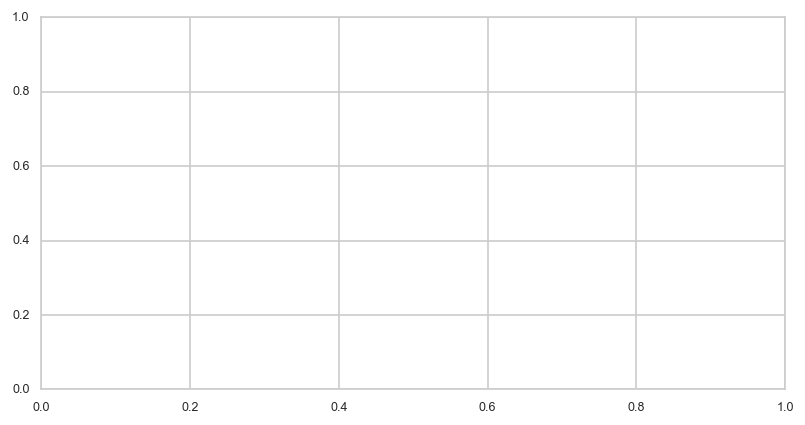

In [16]:
sns.set(style="whitegrid", font_scale=0.75)
f, ax = plt.subplots(figsize=(8, 4))

df, landmarkers, datasetID, datasets = get_landmarkers_from_db()
landmarkers.columns = ['One-Nearest Neighbor', 'Linear Discriminant Analysis', 'Gaussian Naive Bayes', 
                       'Decision Node', 'Random Node']

distance = np.squeeze(get_distance_from_db())
similar_index = compute_similar_datasets(dataset)
sns.violinplot(data=landmarkers.iloc[similar_index], palette="Set3", bw=.2, cut=1, linewidth=1)
sns.despine(left=True, bottom=True) 

In [ ]:
datasets_name = get_datasets_name(datasets, similar_index)
sns.set(style="white")
corr = pd.DataFrame(distance[similar_index[:, None], similar_index], 
                    index = datasets_name, columns = datasets_name)

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(corr, mask=mask, cmap = "BuPu_r", vmax= 1,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})